In [145]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [255]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2024-06-14 02:33:26--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.6’

insurance.csv.6     100%[===================>]  49.09K  --.-KB/s    in 0.006s  

2024-06-14 02:33:26 (7.53 MB/s) - ‘insurance.csv.6’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


# EDA

In [256]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [257]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

- Categorical columns

Sex

In [258]:
dataset.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [259]:
# Map 0 to male and 1 to female

dataset.sex = dataset.sex.map({'male': 0, 'female': 1})

Smoker

In [260]:
dataset.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [261]:
# Map 0 to no and 1 to yes

dataset.smoker = dataset.smoker.map({'no': 0, 'yes': 1})

Region

In [262]:
dataset.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [263]:
# OHE for region column
dataset = pd.get_dummies(dataset, columns=['region'], prefix='', prefix_sep='')

In [264]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   sex        1338 non-null   int64  
 2   bmi        1338 non-null   float64
 3   children   1338 non-null   int64  
 4   smoker     1338 non-null   int64  
 5   expenses   1338 non-null   float64
 6   northeast  1338 non-null   bool   
 7   northwest  1338 non-null   bool   
 8   southeast  1338 non-null   bool   
 9   southwest  1338 non-null   bool   
dtypes: bool(4), float64(2), int64(4)
memory usage: 68.1 KB


# Feature engineering

In [285]:
dataset['young'] = np.where(dataset['age'] < 40, 1, 0)

# Split data

In [286]:
train_dataset = dataset.sample(frac=0.8, random_state=123)
test_dataset = dataset.drop(train_dataset.index)

In [287]:
print(f"Train dataset size: {train_dataset.shape[0]} rows and {train_dataset.shape[1]} columns")
print(f"Test dataset size: {test_dataset.shape[0]} rows and {test_dataset.shape[1]} columns")

Train dataset size: 1070 rows and 11 columns
Test dataset size: 268 rows and 11 columns


# Inspect the data

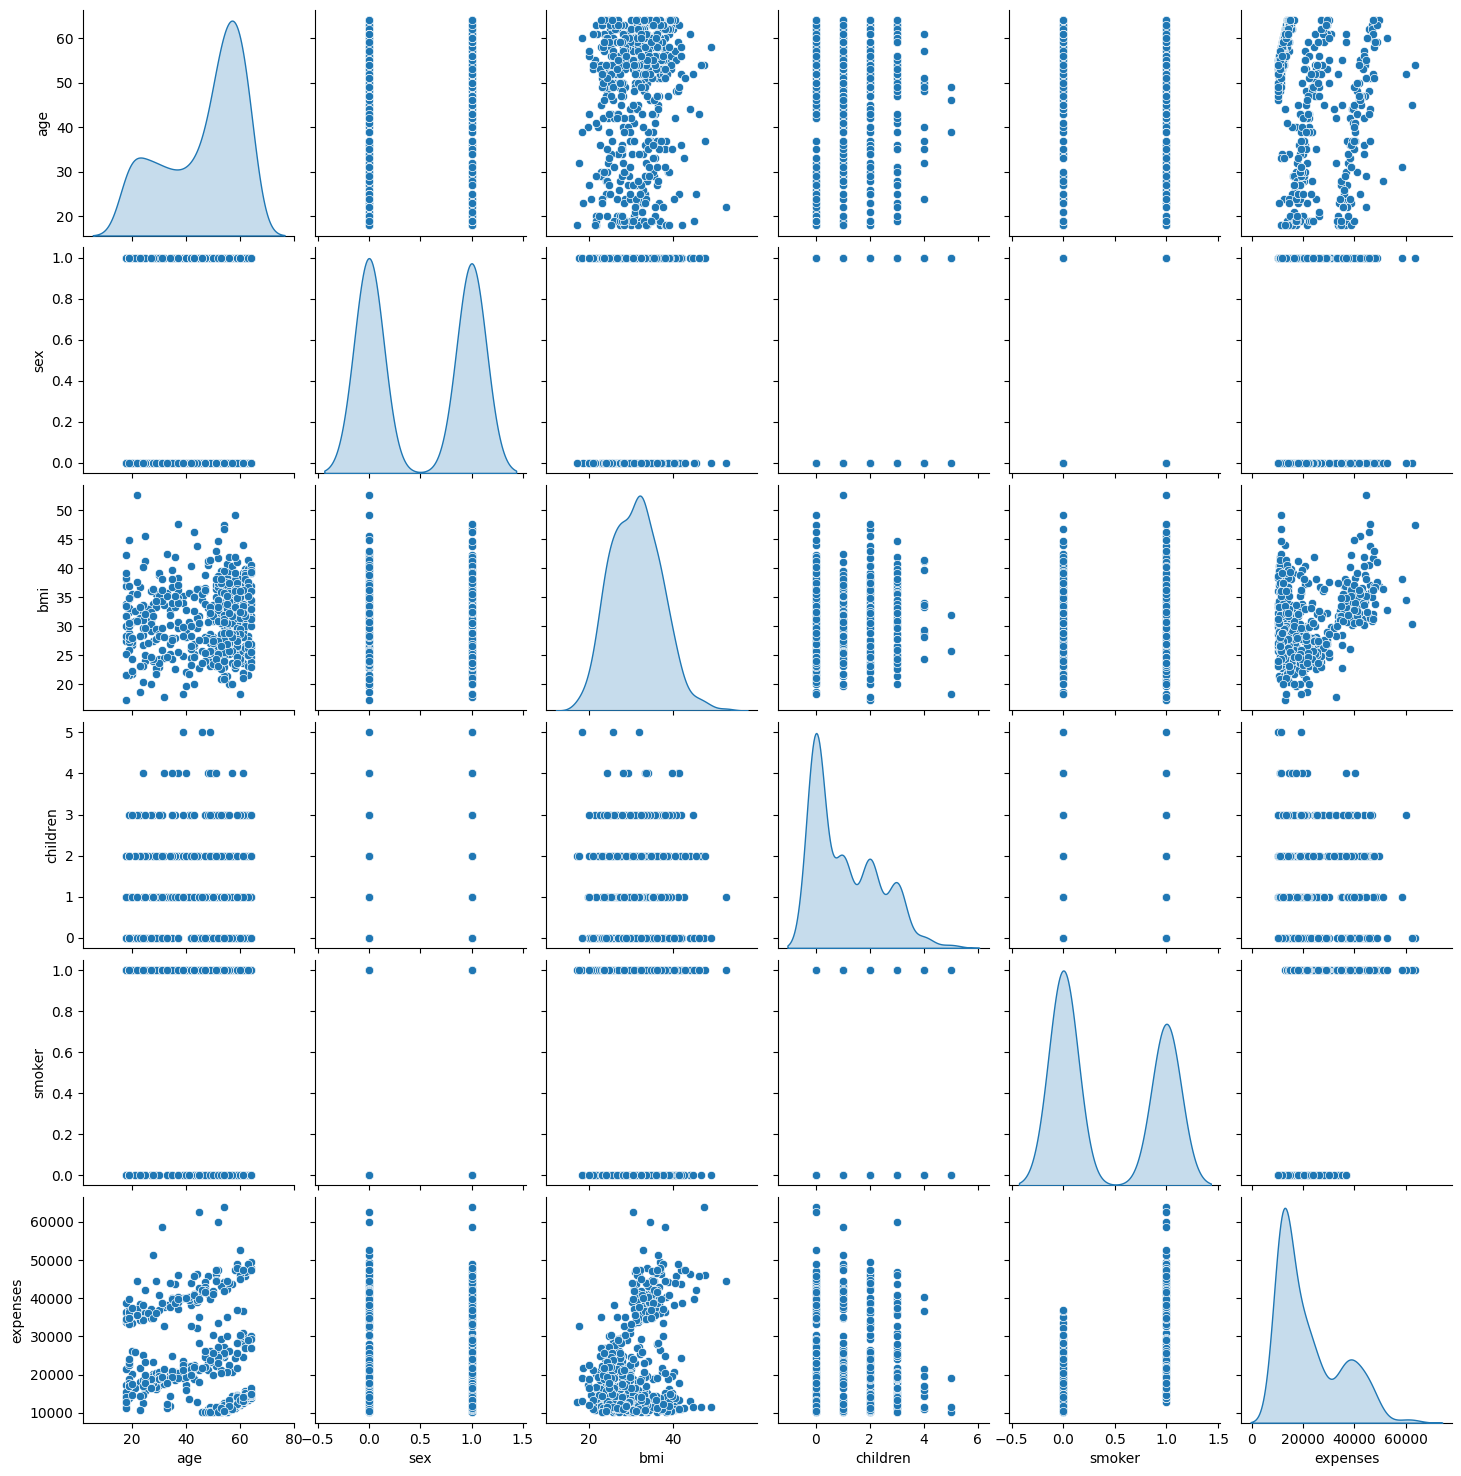

In [253]:
sns.pairplot(
    train_dataset[train_dataset['expenses'] > 10000][['age', 'sex', 'bmi', 'children', 'smoker', 'expenses']],
    diag_kind='kde'
)

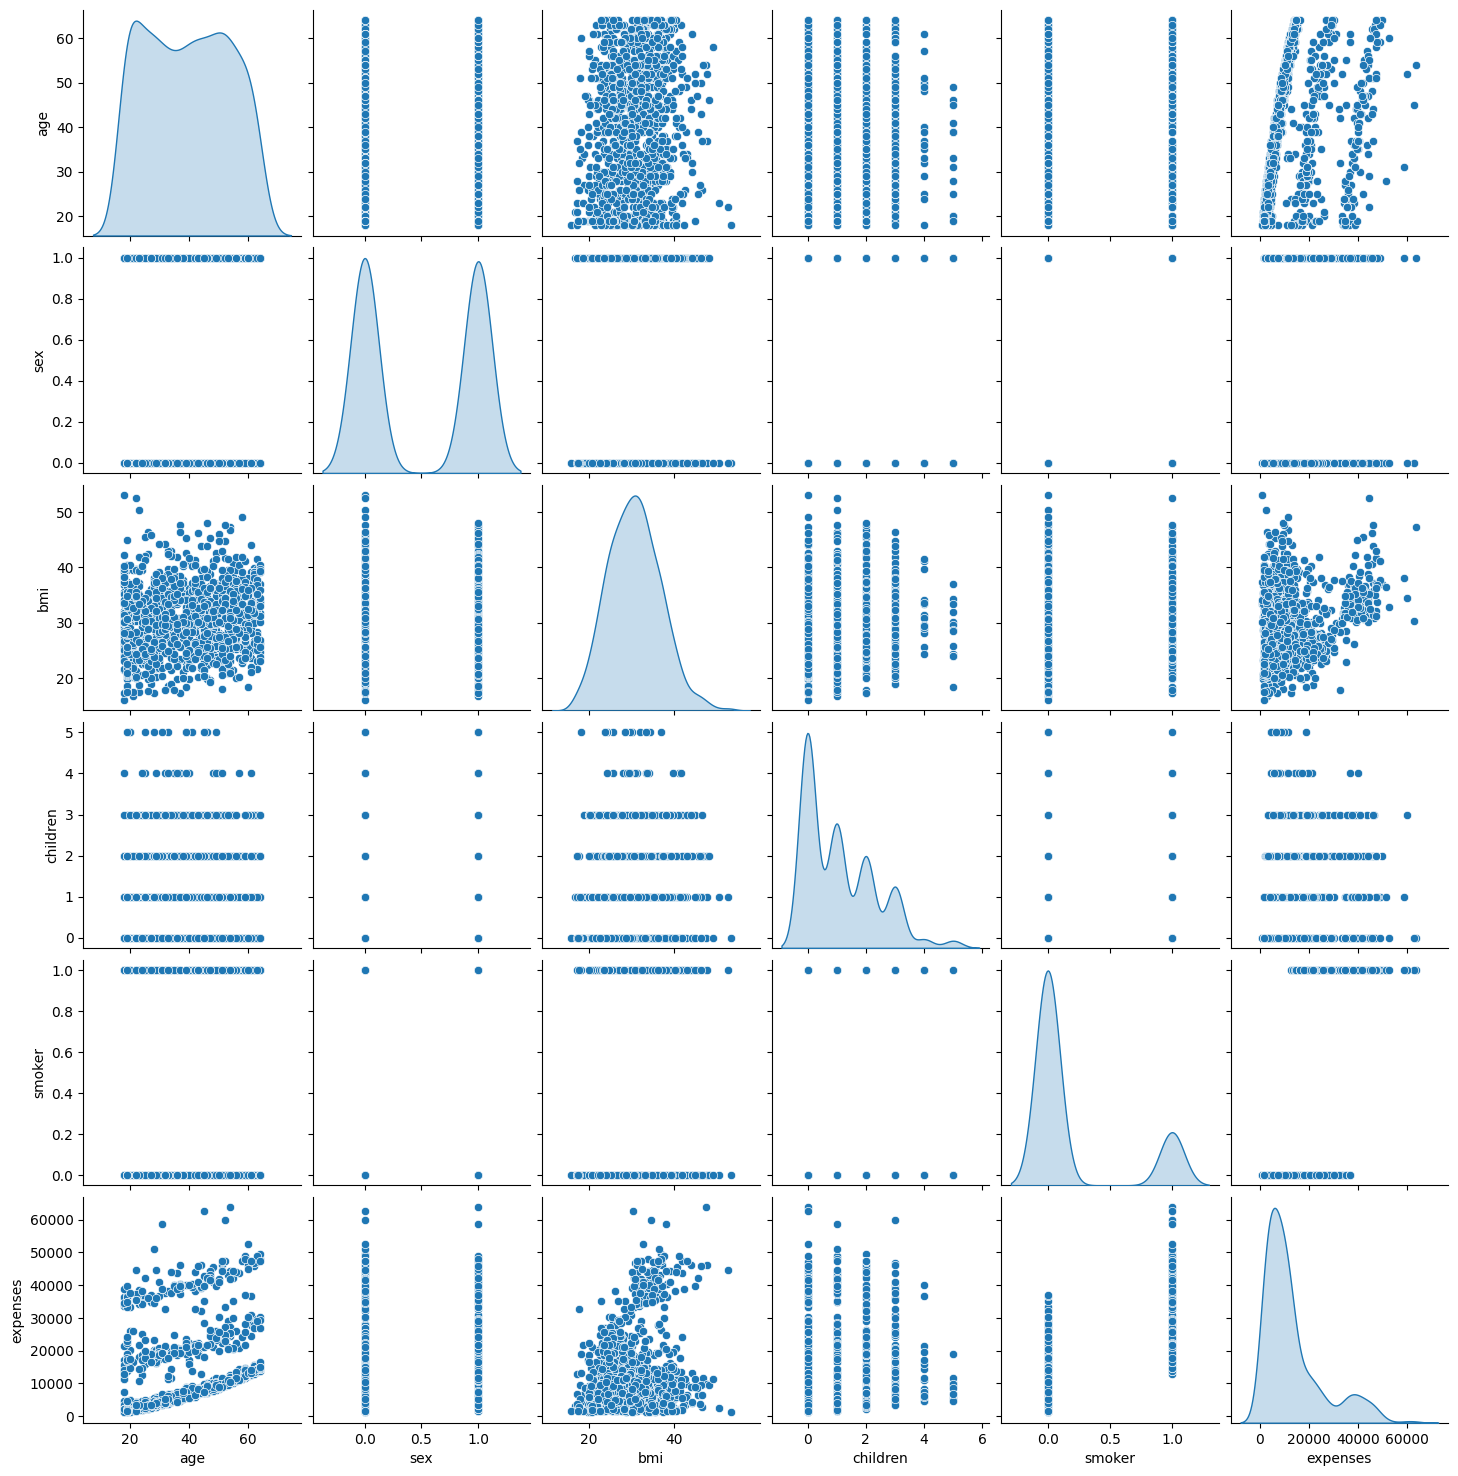

In [158]:
sns.pairplot(
    train_dataset[['age', 'sex', 'bmi', 'children', 'smoker', 'expenses']],
    diag_kind='kde'
)

In [288]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.445794,14.027180,18.00,27.000,40.000,51.0000,64.00
sex,1070.0,0.496262,0.500220,0.00,0.000,0.000,1.0000,1.00
bmi,1070.0,30.666168,6.060178,16.00,26.200,30.500,34.6750,53.10
children,1070.0,1.103738,1.205493,0.00,0.000,1.000,2.0000,5.00
smoker,1070.0,0.198131,0.398778,0.00,0.000,0.000,0.0000,1.00
expenses,1070.0,13146.683888,11983.677732,1131.51,4769.415,9289.085,16107.7575,63770.43
young,1070.0,0.498131,0.500230,0.00,0.000,0.000,1.0000,1.00


# Split features from labels

In [289]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

In [290]:
train_features = train_features.astype(np.float32)
train_labels = train_labels.astype(np.float32)
test_features = test_features.astype(np.float32)
test_labels = test_labels.astype(np.float32)

# Normalization

In [291]:
train_features.describe().T[['mean', 'std']]

,mean,std
age,39.445793,14.027181
sex,0.496262,0.500220
bmi,30.666168,6.060178
children,1.103738,1.205493
smoker,0.198131,0.398778
northeast,0.239252,0.426827
northwest,0.242991,0.429090
southeast,0.271963,0.445179
southwest,0.245794,0.430759
young,0.498131,0.500230


In [292]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [293]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 650 to 943
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1070 non-null   float32
 1   sex        1070 non-null   float32
 2   bmi        1070 non-null   float32
 3   children   1070 non-null   float32
 4   smoker     1070 non-null   float32
 5   northeast  1070 non-null   float32
 6   northwest  1070 non-null   float32
 7   southeast  1070 non-null   float32
 8   southwest  1070 non-null   float32
 9   young      1070 non-null   float32
dtypes: float32(10)
memory usage: 50.2 KB


In [294]:
normalizer.adapt(np.array(train_features))

# Linear regression

In [323]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [324]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.35),
    loss = 'mean_squared_error',
    metrics = ['mean_absolute_error']
)

In [325]:
%%time

history = model.fit(
    train_features,
    train_labels,
    epochs = 3000,
    verbose = True,
    validation_split = 0.2
)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 502/3000
27/27 [==============================] - 0s 5ms/step - loss: 136531504.0000 - mean_absolute_error: 8455.6729 - val_loss: 161316496.0000 - val_mean_absolute_error: 9218.0645
Epoch 503/3000
27/27 [==============================] - 0s 4ms/step - loss: 136298320.0000 - mean_absolute_error: 8446.9199 - val_loss: 161048112.0000 - val_mean_absolute_error: 9209.0850
Epoch 504/3000
27/27 [==============================] - 0s 6ms/step - loss: 136061792.0000 - mean_absolute_error: 8438.1934 - val_loss: 160786992.0000 - val_mean_absolute_error: 9200.2080
Epoch 505/3000
27/27 [==============================] - 0s 5ms/step - loss: 135832304.0000 - mean_absolute_error: 8429.6436 - val_loss: 160508896.0000 - val_mean_absolute_error: 9190.9307
Epoch 506/3000
27/27 [==============================] - 0s 5ms/step - loss: 135597600.0000 - mean_absolute_error: 8420.8018 - val_loss: 160237344.0000 - val_mean_absolute_error: 9181.7080

In [326]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
2995,34471852.0,3983.024414,39049356.0,4087.957764,2995
2996,34471864.0,3983.271240,39051440.0,4088.080078,2996
2997,34472940.0,3983.305176,39051412.0,4087.871094,2997
2998,34473452.0,3983.222900,39048700.0,4087.495850,2998
2999,34473344.0,3983.114502,39052040.0,4088.015137,2999


In [327]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [expenses]')
  plt.legend()
  plt.grid(True)

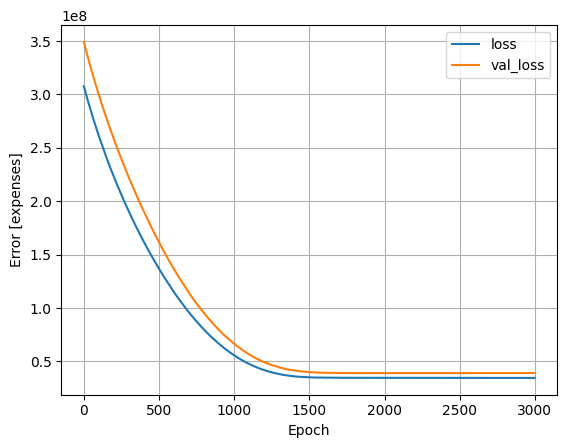

In [328]:
plot_loss(history)

In [329]:
model.evaluate(test_features, test_labels, verbose=True)

9/9 [==============================] - 0s 3ms/step - loss: 41469352.0000 - mean_absolute_error: 4449.2988


[41469352.0, 4449.298828125]

# Evaluate model

9/9 [==============================] - 0s 4ms/step - loss: 41469352.0000 - mean_absolute_error: 4449.2988
Testing set Mean Abs Error: 4449.30 expenses
The Mean Abs Error must be less than 3500. Keep trying.
9/9 [==============================] - 0s 4ms/step


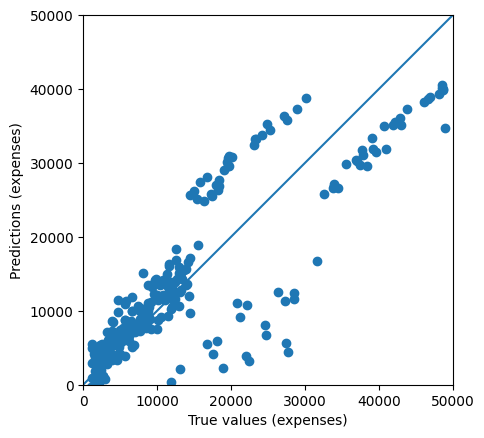

In [330]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae = model.evaluate(test_features, test_labels, verbose=True)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)


In [138]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/normalization_5/sub defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-138-c55f6c3fdc4f>", line 3, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/normalization.py", line 362, in call

Incompatible shapes: [32,9] vs. [1,10]
	 [[{{node sequential_1/normalization_5/sub}}]] [Op:__inference_test_function_36020]